# 20/05/17

Looked up papers on using using tied states vs phoneme states. (review here https://docs.google.com/document/d/17VhroitGucKZoqIEYZLYoK8y62Kw2L-h0o2uCZpG9gc/edit?usp=sharing)

Dahl, George E., et al. "Context-dependent pre-trained deep neural networks for large-vocabulary speech recognition." IEEE Transactions on Audio, Speech, and Language Processing 20.1 (2012): 30-42. used tied states

# 27/05/17

In [ ]:
#feature extraction code
from python_speech_features import fbank
import numpy as np
from scipy.io import wavfile
from scipy.signal import hamming
import os
root = '/home/mshah1/wsj/wsj0/'
fileList = root + 'wsj0.wavlist'
with open(fileList,'r') as f:
	files = f.readlines()
	files = map(lambda x: x.strip(), files)

for f in files:
	if not os.path.exists(root + f + '.mls'):
		print f
		(rate,data) = wavfile.read(root + f)
		(feat,_) = fbank(data,samplerate=rate,winlen=0.025,
							winstep=0.015,nfilt=40,nfft=1024,
							lowfreq=250,winfunc=hamming)
		feat = np.log(feat)
		np.savetxt(root + f + '.mls',feat)

In [ ]:
#random label assignment code
def fileToLabels(data, nPhones=30):	
	nFrames = data.shape[0]
	nPhones = nPhones + np.random.randint(-5,high=5)
	segLen = nFrames / nPhones
	labels = []
	for i in range(nPhones):
		currSegLen = segLen + np.random.randint(-10,high=10)
		labels += [np.random.randint(0,high=3000)]*min(currSegLen,nFrames - len(labels))
	return labels

In [ ]:
#MLP1:
#classification accuracy an abysmal 0.00033
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.models import load_model
import numpy as np

data = np.load('wsj0_randlabels.npz')
model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_dim=40))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(3000, activation='softmax'))
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
x_train = data['X_Train'][:1000000]
y_train = data['Y_Train'][:1000000]
y_train = to_categorical(y_train, num_classes = 3000)
model.fit(x_train,y_train,epochs=10,batch_size=20000)
model.save("mlp_randomAlign.h5")

Changed winstep to 0.01, accuracy went up to 0.00054

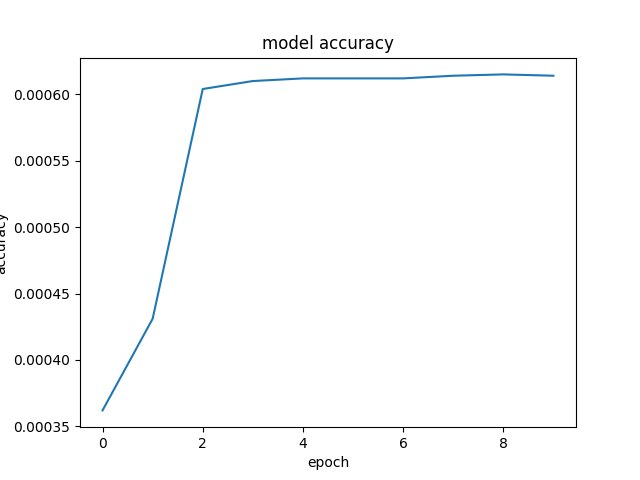

Changed optimizer to rmsprop accuracy went down to 0.00031

accuracy with 250000 testing samples with adagrad = 0.00035

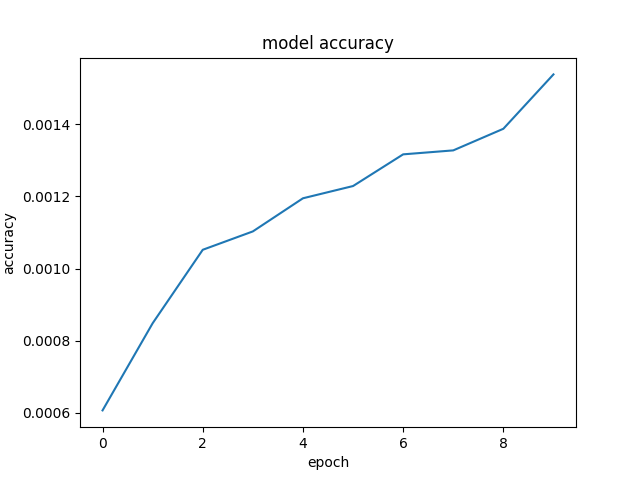

accuracy with relu activations = 0.00031 (training accuracy went up significantly to 0.014)

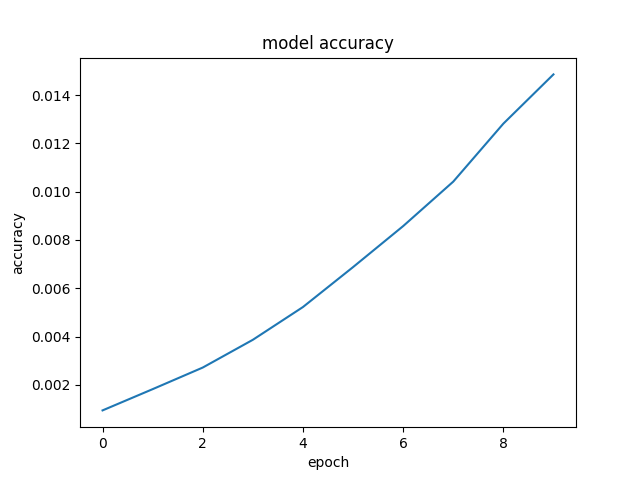

In [ ]:
# MLP3: Deeper MLP model  
# accuracy is 0.00032
def mlp3():
	model = Sequential()
	model.add(Dense(500, activation='relu', input_dim=40))
	model.add(Dropout(0.25))
	model.add(Dense(500, activation='relu'))
	model.add(Dropout(0.25))
	model.add(Dense(500, activation='relu'))
	model.add(Dropout(0.25))
	model.add(Dense(500, activation='relu'))
	model.add(Dropout(0.25))
	model.add(Dense(3000, activation='softmax'))
	model.compile(optimizer='adagrad',
	              loss='categorical_crossentropy',
	              metrics=['accuracy'])
	return model

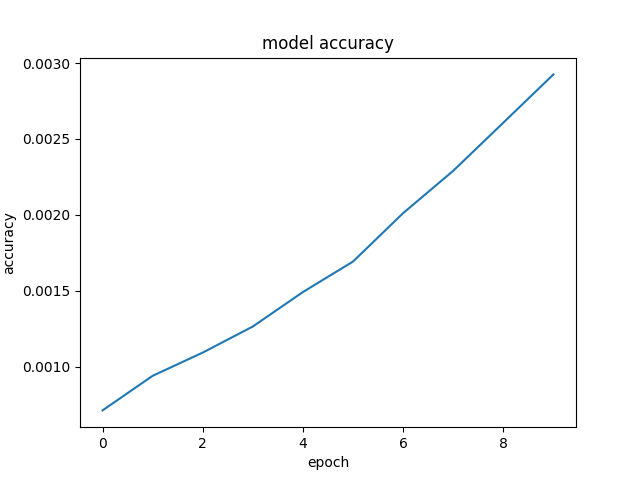

# 28/5/17

Tried using sphinx3_align,, threw the following error
ERROR: "main_align.c", line 974: Uttid mismatch: ctlfile =
  "02aa010i.wv2.flac"; transcript =
  "11_10_1/wsj0/sd_tr_s/00f/00fc031m.wv2"
 
  INFO: feat.c(1205): At directory feat/
 
  INFO: feat.c(1022): Reading mfc file:
  'feat//./11_8_1/wsj0/si_tr_s/02a/02aa010i.wv2.flac.mfc'[0..-1]
 
  INFO: cmn.c(175): CMN: 49.71 -5.35 -6.24  8.33  5.61  7.87 -3.84
  -1.53
  -6.34
  -13.66 -11.63 -8.54 -13.30
 
  INFO: main_align.c(1009): 02aa010i.wv2.flac: 465 input frames
 
 
 
  ERROR: "main_align.c", line 891: Final state not reached; no
  alignment
  for
  02aa010i.wv2.flac


# 30/5/17

Setup sphinx3 on genie

# 1/6/17

Refactored the transcripts and the ctlist so that filenames match
Error persists

# 5/6/17

In [ ]:
# re-ran feature extraction using sphinx_fe
sphinx_fe -argfile ~/wsj_all_cd30.mllt_cd_cont_4000/feat.params -c etc/wsj0_train.fileids -di wav/ -do feat/ -mswav yes -eo mfc -ei wav

In [ ]:
# Re-ran alignment and obtained state-level segmentations
sphinx3_align -hmm ~/wsj_all_cd30.mllt_cd_cont_4000/ -dict transcripts/wsj0/cmudict.0.6d.wsj0 -ctl etc/wsj0_train.fileids -cepdir feat/ -cepext .mfc -insent transcripts/wsj0/wsj0.trans2 -outsent wsj0.out -lda ~/wsj_all_cd30.mllt_cd_cont_4000/feature_transform -cmn batch -stsegdir statesegdir

# 6/6/17

In [ ]:
# code for reading .stseg files and saving them as ASCII (slightly modified from the version found 
# online since the types didn't match)

/* ====================================================================
 * Copyright (c) 1995-2002 Carnegie Mellon University.  All rights
 * reserved.
 *
 * Redistribution and use in source and binary forms, with or without
 * modification, are permitted provided that the following conditions
 * are met:
 *
 * 1. Redistributions of source code must retain the above copyright
 *    notice, this list of conditions and the following disclaimer.
 *
 * 2. Redistributions in binary form must reproduce the above copyright
 *    notice, this list of conditions and the following disclaimer in
 *    the documentation and/or other materials provided with the
 *    distribution.
 *
 * This work was supported in part by funding from the Defense Advanced
 * Research Projects Agency and the National Science Foundation of the
 * United States of America, and the CMU Sphinx Speech Consortium.
 *
 * THIS SOFTWARE IS PROVIDED BY CARNEGIE MELLON UNIVERSITY ``AS IS'' AND
 * ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO,
 * THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
 * PURPOSE ARE DISCLAIMED.  IN NO EVENT SHALL CARNEGIE MELLON UNIVERSITY
 * NOR ITS EMPLOYEES BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
 * SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
 * LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
 * DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
 * THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
 * (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
 * OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
 *
 * ====================================================================
 *
 */
/*
 * stseg.c -- Read and display .stseg file created by s3align.
 *
 * **********************************************
 * CMU ARPA Speech Project
 *
 * Copyright (c) 1996 Carnegie Mellon University.
 * ALL RIGHTS RESERVED.
 * **********************************************
 *
 * HISTORY
 *
 * 19-Jul-96    M K Ravishankar (rkm@cs.cmu.edu) at Carnegie Mellon University
 *              Created.
 */


#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <assert.h>
#include <stdint.h>

/* "\nCI.8 LC.8 RC.8 POS.3(HI)-ST.5(LO) SCR(32)" */

static char *phone[100];
static int n_phone;
static char *posname = "besiu";


static skip_line (FILE *fp)
{
    int c;

    while (((c = fgetc (fp)) >= 0) && (c != '\n'));
}


main ()
{
    int i, k, nf, scr;
    int16_t c;
    FILE *fp;
    int16_t str[3];
    char str1[1024];
    fp = stdin;
    n_phone = 0;

    /* Skip version# string */
    skip_line (fp);

    /* Read CI phone names */
    for (;;) {
        for (i = 0;; i++) {
            if (((c = fgetc(fp)) == ' ') || (c == '\n'))
                break;
            str1[i] = c;
        }
        str1[i] = '\0';

        if (c == ' ') {
            phone[n_phone] = (char *) malloc (i+1);
            strcpy (phone[n_phone], str1);
            n_phone++;
        } else
            break;
    }
    printf ("%d phones\n", n_phone);

    /* Skip format line */
    skip_line (fp);

    /* Skip end-comment line */
    skip_line (fp);

    /* Read byteorder magic no. */
    fread (&i, sizeof(int), 1, fp);
    assert (i == 0x11223344);

    /* Read no. frames */
    fread (&nf, sizeof(int), 1, fp);
    printf ("#frames = %d\n", nf);

    char pos[1];
    /* Read state info per frame */
    for (i = 0; i < nf; i++) {
        k = fread (str, sizeof(uint16_t), 3, fp);
        str[3] = 0;
        assert (k == 3);
        k = fread (pos, sizeof(char), 1, fp);
        assert (k == 1);
        k = fread (&scr, sizeof(int), 1, fp);
        assert (k == 1);

        c = str[0];
        //printf("c=%d\n",c);
        assert ((c >= 0) && (c < n_phone));
        printf ("%5d %11d %2d %s", i, scr, pos[0] & 0x001f, phone[c]);

        c = str[1];
        //printf("c2=%d\n",c);
        if (c != -1) {
            assert ((c >= 0) && (c < n_phone));
            printf (" %s", phone[c]);
        }

        c = str[2];
        //printf("c3=%d\n",c);
        if (c != -1) {
            assert ((c >= 0) && (c < n_phone));
            printf (" %s", phone[c]);
        }

        c = (pos[0] >> 5) & 0x07;
        if ((c >= 0) && (c < 4))
            printf (" %c", posname[c]);

        printf ("\n");
    }
}


Example alignment output
44 phones
#frames = 349
    0      -32931  0 SIL
    1      -29131  1 SIL
    2      -21946  2 SIL
    3      -11502  2 SIL
    4        -661  2 SIL
    5       -8628  2 SIL
    6      -15577  2 SIL
    7       -9964  0 DH SIL AH e
    8       -9648  1 DH SIL AH e
    9       -5518  1 DH SIL AH e

# 7/6/17

In [ ]:
# Extract Mel-Log Likelihood Using sphinx_fe
sphinx_fe -argfile ~/wsj_all_cd30.mllt_cd_cont_4000/feat.params -c etc/wsj0_train.fileids -di feat/ -do feat_spec/ -eo mls -ei mfc -cep2spec yes -ofmt text

In [ ]:
# Mapped the alignments to phoneme states (not tied states, just the state corresponding to the base phone and the position)
# using the following script

def read_sen_labels_from_mdef(fname, onlyPhone=True):
#     create a phoneme-senoneID dictionary using a mdef file
#     inputs: mdef file
#     outputs: phoneme-senoneID dictionary
	labels = np.loadtxt(fname,dtype=str,skiprows=10,usecols=(0,6,7,8))
	if onlyPhone:
		labels = labels[:44]
	phone2state = {}
	for r in labels:
		phone2state[r[0]] = map(int, r[1:])
	return phone2state

def frame2state(fname, phone2state, onlyPhone=True):
#     determine the senoneID for a frame (a row in the alignment file)
#     inputs: alignment file (in ASCII), phoneme-senoneID dictionary
#     output: list of states indexed according to frame numbers
	with open(fname,'r') as f:
		lines = f.readlines()[2:]
	lines = map(lambda x: x.split()[2:], lines)
	if onlyPhone:
		lines = map(lambda x: x[:2],lines)
	else:
		lines = map(lambda x: [x[0], reduce(lambda a,b: a+' '+b,x[1:])],lines)
	states = map(lambda x: phone2state[x[1]][int(x[0])], lines)
	return (list(states))

def genDataset(DB_path, filelist, stseg_path, mdef_fname):
	files = np.loadtxt(DB_path+filelist,dtype=str)
	files = map(lambda x: DB_path+x,files)
	fileWOpath = map(lambda x: x.split('/')[-1][:-3]+'stseg.txt',files)
	stseg_files = filter(lambda x: os.path.exists(DB_path + stseg_path + x), fileWOpath)
	phone2state = read_sen_labels_from_mdef(mdef_fname)
	allData = []
	allLabels = []
	for f in (stseg_files):
		data_file = filter(lambda x: f[:-9] in x, files)[0]
		print data_file, f
		data = np.loadtxt(data_file)
		labels = frame2state(DB_path + stseg_path + f, phone2state)
		nFrames = min(len(labels), data.shape[0])
		data = data[:nFrames]
		labels = labels[:nFrames]
		assert(len(labels) == data.shape[0])
		allData += list(data)
		allLabels += list(labels)
		assert(len(allLabels) == len(allData))
	# print allData
	print len(allData), len(allLabels)
	lenTrain = len(allData) * 3 / 4
	X_Train = allData[:lenTrain]
	Y_Train = allLabels[:lenTrain]
	X_Test = allData[lenTrain:]
	Y_Test = allLabels[lenTrain:]
	np.savez('wsj0_phonelabels',X_Train=X_Train,Y_Train=Y_Train,X_Test=X_Test,Y_Test=Y_Test)

Running test with MLPs
Training set: 30,040,440 frames
Testing set: 10,013,481 frames

MLP3: testing accuracy = 20.8%
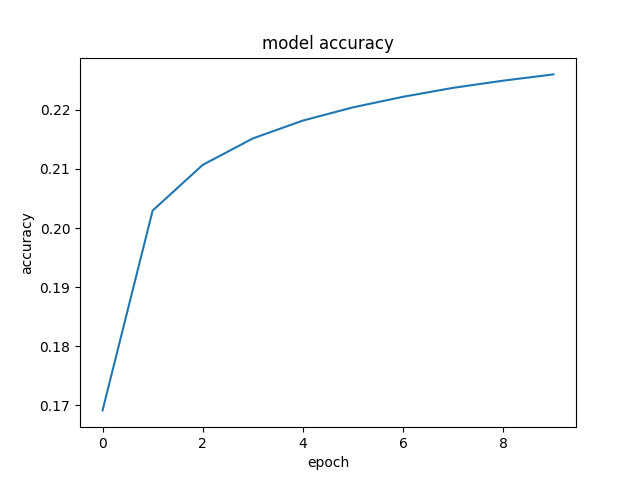

MLP1: testing accuracy = 19.4 %
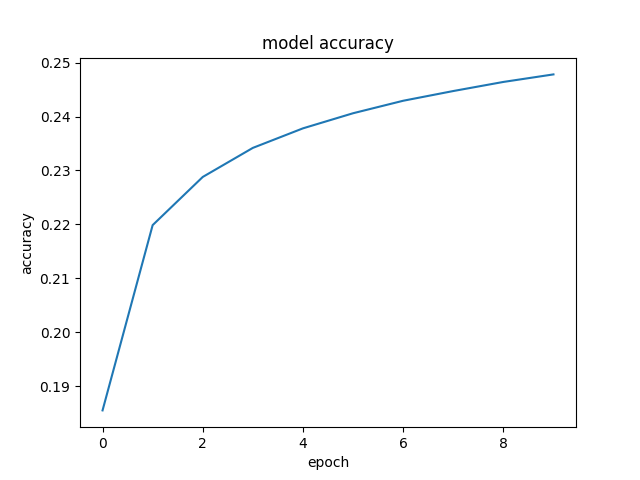

In [ ]:
# Basic resnet 
def make_dense_res_block(inp, size):
	x = inp
	for i in range(size):
		x = Dense(500, activation='relu')(x)
		x = Dropout(0.25)(x)
	return x

def mlp4(input_dim,output_dim,nBlocks):
	inp = Input(shape=(input_dim,))
	x = Dense(500, activation='relu')(inp)
	for i in range(nBlocks):
		y = make_res_block(x,2)
		x = add([x,y])
	z = Dense(output_dim, activation='softmax')(x)
	model = Model(inputs=inp, outputs=z)
	model.compile(optimizer='rmsprop',
	              loss='categorical_crossentropy',
	              metrics=['accuracy'])
	return model

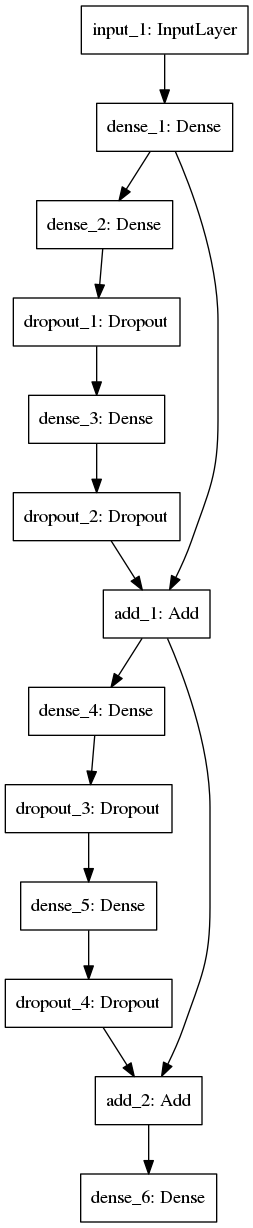

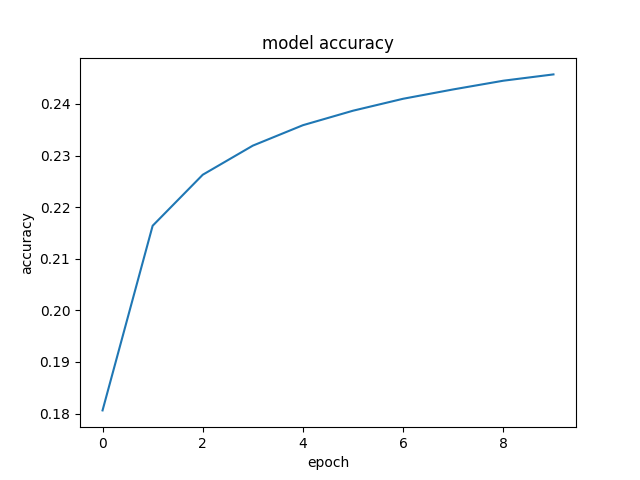

Testing accuracy: 19.25%

Making a deeper network with 10 residual blocks

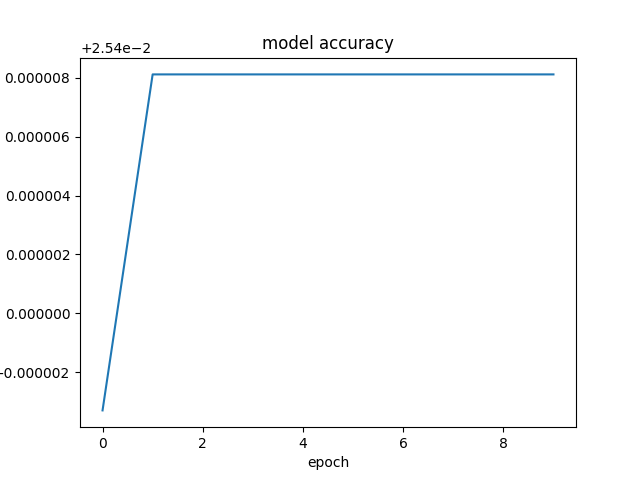

testing accuracy = 2.5%

- widen the first layer in mpl3
- use +- 4 frames and use the labels for the central vector
- replace the output layer and see
- replicate Hinton's paper 

# 8/6/17

MLP3 with 3000 neurons in the first layer
training accuracy: 22.98%
testing accuracy: 19.71%

# 9/6/17

In [ ]:
# Added code to append context frames and generated the dataset again with context_len=4
if context_len != None:
			pad_top = np.zeros((context_len,data.shape[1])) + data[0]
			pad_bot = np.zeros((context_len,data.shape[1])) + data[-1]
			padded_data = np.concatenate((pad_top,data),axis=0)
			padded_data = np.concatenate((padded_data,pad_bot),axis=0)

			data = []
			for i in range(context_len,len(padded_data) - context_len):
				new_row = padded_data[i - context_len: i + context_len + 1]
				new_row = new_row.flatten()
				data.append(new_row)

# 11/6/17

MLP3 with 3000 neurons in the first layer and 1000 neurons in the hidden layers (with bracketed features)
training accuracy: 3.32%
testing accuracy: 2.81%

In [ ]:
# code for layer-wise pretraining NNs
def preTrain(model,x_train,y_train,skip_layers):
	print model.summary()
	layers = model.layers
	output = layers[-1]
	outdim = output.output_shape[1]
	for i in range(len(layers) - 1):
		if i in skip_layers:
			print 'skipping layer ',i
			continue
		if len(model.layers[i].get_weights()) == 0:
			continue
		last = model.layers[i].output
		preds = Dense(outdim,activation='softmax')(last)
		model_new = Model(model.input,preds)
		for j in range(i):
			model_new.layers[j].trainable=False
		model_new.compile(optimizer='adagrad',
	              loss='categorical_crossentropy',
	              metrics=['accuracy'])
		print model_new.summary()
		model_new.fit(x_train,y_train,epochs=1,batch_size=2048)
		model.layers[i].set_weights(model_new.layers[-2].get_weights())
	return model

1 layer NN with 4636 neurons training accuracy = 1.70% (with bracketed features and pretraining)

3 layer NN with 2048 neurons, training accyracy = 3.31% (with bracketed features and pretraining)

I am thinking that bracketed features may not be a very good idea
Non-bracketed features provide 8% accuracy without any hidden layers

# 13/6/17

In [ ]:
# Implementation of the DBN-DNN model as mentioned in the Hinton paper
def trainDBN_DNN(x_train,y_train,depth,width):
	input_dim = x_train.shape[1]
	inp = x_train
	weights = []
	bias = []
	batch_size = 500000
	n_batches = (x_train.shape[0] / batch_size) + (1 if x_train.shape[0]%batch_size != 0 else 0)
	temp_arr = np.zeros((batch_size * n_batches, width))
	for i in range(depth):
		print 'training DBN layer', i
		if i == 0:
			rbm = GBRBM(n_visible=input_dim,n_hidden=width,learning_rate=0.01, momentum=0.95, use_tqdm=True)
		else:
			rbm = BBRBM(n_visible=input_dim,n_hidden=width,learning_rate=0.01, momentum=0.95, use_tqdm=True)
		rbm.fit(inp,n_epoches=10,batch_size=20000,shuffle=False)
		(W,_,Bh) = rbm.get_weights()
		weights.append(W)
		bias.append(Bh)
		print 'batch transforming data...'
		for j in range(n_batches):
			stdout.write("\r%d batch no %d/%d" % (int(time.time()),j+1,n_batches))
			stdout.flush()
			b = np.array(inp[j*batch_size:min((j+1)*batch_size, inp.shape[0])])
			T = rbm.transform(b)
			temp_arr[j*batch_size:min((j+1)*batch_size, inp.shape[0])] = T
		inp = temp_arr
		stdout.write("\n")
		stdout.flush()
		print 'batch transform finished...'
		input_dim = inp.shape[1]

	model = mlp1(x_train.shape[1],y_train.shape[1],depth-1,width)
	print len(weights), len(model.layers)
	assert len(weights) == len(model.layers) - 1
	for i in range(len(weights)):
		W = [weights[i],bias[i]]
		model.layers[i].set_weights(W)
	return model

# 15/6/17

MLP with no hidden layer: 18% training and 16% testing accuracy (with bracketed features)

# 16/6/17

Mean Normalized training set: training acc = 57.34% testing acc = 48.5%

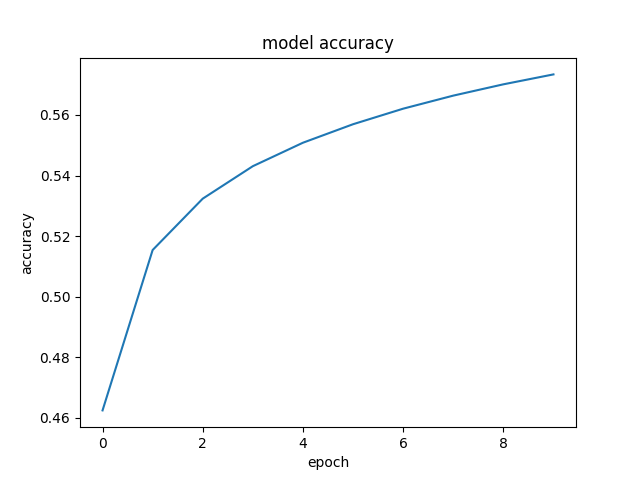

Standardizing the data: Training acc = 55% Testing Acc: 48.3%

# 17/6/17

- Refactored dataset compilation code to use the training, test and dev sets in wsj0
- Normalizing each utterance individually

# 18/6/17

In [ ]:
# implementated callback to enable getting dev set accuracy at each training epoch
# This callback extends the history callback in Keras by running an evaluation on the test data after each epoch
# and adding the results to the history object returned by model.fit.
# The evaluation loss and accuracy can be accessed by referencing keywords 'eval_loss' and 'eval_acc'
class TestCallback(History):
    def __init__(self, test_data):
        self.test_data = test_data
    def on_train_begin(self,logs=None):
    	super(TestCallback,self).on_train_begin(logs)
    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        logs['eval_loss'] = loss
        logs['eval_acc'] = acc
        super(TestCallback,self).on_epoch_end(epoch, logs)
        print('\nTesting loss: {}, Testing acc: {}\n'.format(loss, acc))

Mean-Normalizing each utterance, 3x2048 mlp with sigmoid activation and adagrad optimizer: training acc= 58.24 testing acc = 52.2%

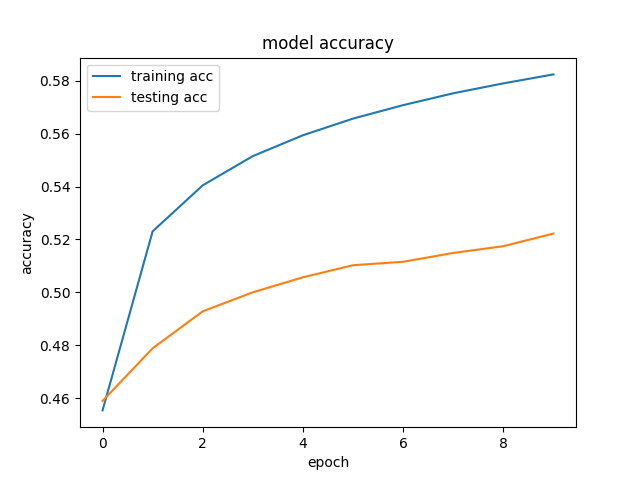

In [2]:
from IPython.display import Image, display
display(Image(filename='mlp1-3x2048-sig-adagrad.png', embed=True))

Standardizing each utterance, 3x2048 mlp with sigmoid: training acc= 57.60 testing acc = 51.11%

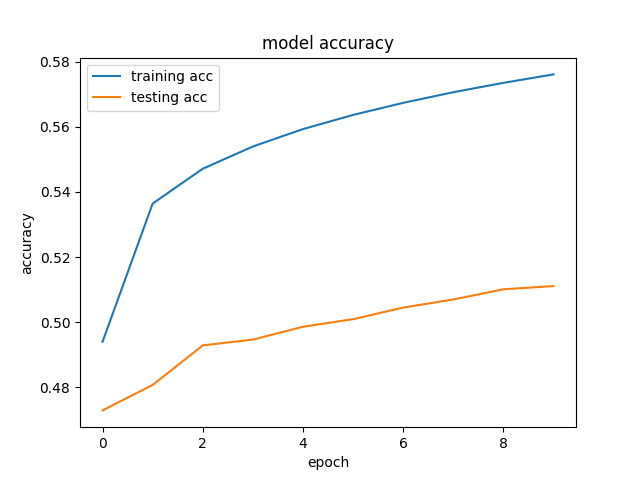

In [5]:
from IPython.display import Image, display
display(Image(filename='mlp1-3x2048-sig-adagrad-varnorm.png', embed=True))

# 21/6/17

In [ ]:
#Decoding using pocketsphinx to get baseline scores
# I used the gigaword 64K trigram model with verbal punctuations and the cmu dict that ships with Pocketsphinx
pocketsphinx_batch -hmm ../../wsj_all_cd30.mllt_cd_cont_4000/ -lm ../../lm_giga_64k_vp_3gram/lm_giga_64k_vp_3gram.arpa -cepdir feat/ -lda ../../wsj_all_cd30.mllt_cd_cont_4000/feature_transform -cmn batch -hyp test2.hyp -ctl etc/wsj0_dev.fileids

3x2048 mlp with sigmoid activation and adagrad optimizer and dropout after layer 2 and 3: training acc= 55.9 testing acc = 52.07%

Layer (type)                 Output Shape              Param #

=================================================================
dense_1 (Dense)              (None, 2048)              481280
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0
_________________________________________________________________
dense_4 (Dense)              (None, 132)               270468
=================================================================


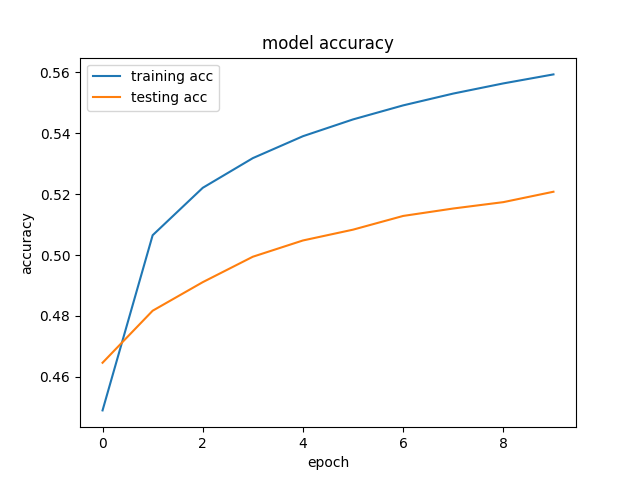

In [3]:
from IPython.display import Image, display
display(Image(filename='mlp1-3x2048-sig-adagrad-drop.png', embed=True))

3x2048 mlp with sigmoid activation and adagrad optimizer with batch normalization and dropout after layer 2 and 3: training acc= 58.43 testing acc = 54.38%

Layer (type)                 Output Shape              Param #

=================================================================
dense_1 (Dense)              (None, 2048)              481280
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192
_________________________________________________________________
dense_4 (Dense)              (None, 132)               270468
=================================================================


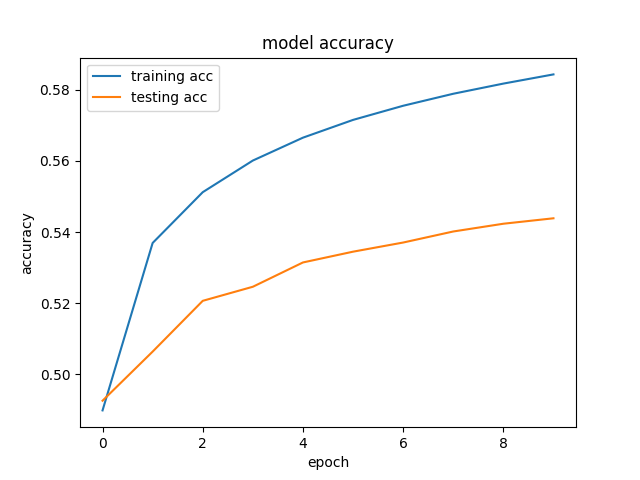

In [4]:
from IPython.display import Image, display
display(Image(filename='mlp1-3x2048-sig-adagrad-drop-bn.png', embed=True))

# 22/6/17

Baseline results from pocketSphinx decode on WSJ0 development set
TOTAL Words: 195050 Correct: 143449 Errors: 55678
TOTAL Percent correct = 73.54% Error = 28.55% Accuracy = 71.45%
TOTAL Insertions: 4077 Deletions: 16300 Substitutions: 35301

In [ ]:
 pocketsphinx_batch -hmm ../../wsj_all_cd30.mllt_cd_cont_4000/ -lm ../../tcb20onp.Z.DMP -cepdir feat/ -lda ../../wsj_all_cd30.mllt_cd_cont_4000/feature_transform -cmn batch -hyp test2.hyp -ctl etc/wsj0_dev.fileids -dict etc/cmudict.0.6d.wsj0 -lw 10 -beam 1e-80 -wbeam 1e-40 -bestpath no -fwdflat no

# 24/6/17

In [ ]:
# code for writing result vector of the MLP in senone dump format to be used as input to the decoder
# Using logbase 1.0007 instead of the default 1.0001 in pocketsphinx_batch
# n_sen currently 132 becuase we are doing phoneme level recognition

def writeSenScores(filename,scores):
	n_active = scores.shape[1]
	s = """s3
version 0.1
mdef_file ../../wsj_all_cd30.mllt_cd_cont_4000//mdef
n_sen 132
logbase 1.000100
endhdr
"""
	s += struct.pack('l',0x11223344)
	scores = np.log(scores)/np.log(1.0007)
	truncateToShort = lambda x: 32676 if x > 32767 else (-32768 if x < -32768 else x)
	for r in scores:
		s += struct.pack('h',n_active)
		r_str = map(lambda x: struct.pack('h',truncateToShort(x)),r)
		r_str = reduce(lambda x,y: x+y,r_str)
		s += r_str
	with open(filename,'w') as f:
		f.write(s)
        
def getPreds(model,filelist,file_dir,file_ext,res_dir,res_ext,context_len=4):
	with open(filelist) as f:
		files = f.readlines()
		files = map(lambda x: x.strip(),files)
	filepaths = map(lambda x: file_dir+x+file_ext,files)[:500]
	scaler = StandardScaler(copy=False,with_std=False)
	for i in range(len(filepaths)):
		stdout.write("\r%d/%d 	" % (i,len(filepaths)))
		stdout.flush()

		f = filepaths[i]
		data = np.loadtxt(f)
		data = scaler.fit_transform(data)

		pad_top = np.zeros((context_len,data.shape[1])) + data[0]
		pad_bot = np.zeros((context_len,data.shape[1])) + data[-1]
		padded_data = np.concatenate((pad_top,data),axis=0)
		padded_data = np.concatenate((padded_data,pad_bot),axis=0)

		data = []
		for j in range(context_len,len(padded_data) - context_len):
			new_row = padded_data[j - context_len: j + context_len + 1]
			new_row = new_row.flatten()
			data.append(new_row)
		data = np.array(data)
		preds = model.predict(data)
		res_file_path = res_dir+files[i]+res_ext
		dirname = os.path.dirname(res_file_path)
		if not os.path.exists(dirname):
			os.makedirs(dirname)
		writeSenScores(res_file_path,preds)

In [ ]:
# commandline for running the decoder on sen files
 pocketsphinx_batch -hmm ../../wsj_all_cd30.mllt_cd_cont_4000/ -lm ../../tcb20onp.Z.DMP -cepdir senscores/ -cepext .sen -lda ../../wsj_all_cd30.mllt_cd_cont_4000/feature_transform -cmn batch -hyp NN.hyp -ctl etc/wsj0_dev.fileids -ctlcount 500 -dict etc/cmudict.0.6d.wsj0 -lw 10 -beam 1e-80 -wbeam 1e-40 -bestpath no -fwdflat no -remove_noise no -remove_silence no -senin yes -compallsen yes -logbase 1.0007

Decoding results

 (11_12_1/wsj0/sd_dt_05/001/001c0q01.wv2.flac 47132848)
BOY (11_12_1/wsj0/sd_dt_05/001/001c0q02.wv2.flac 45941306)
AWE (11_12_1/wsj0/sd_dt_05/001/001c0q03.wv2.flac 16980208)
U. (11_12_1/wsj0/sd_dt_05/001/001c0q04.wv2.flac 15591085)
ZHAO JOY COW U. (11_12_1/wsj0/sd_dt_05/001/001c0q05.wv2.flac 43469419)
A ZHAO JUNG ZHAO (11_12_1/wsj0/sd_dt_05/001/001c0q06.wv2.flac 27162644)


# 25/6/17

Results for 3x2048 MLP with DBN-DNN pre-training
training acc: 57.52% testing acc: 51.61%

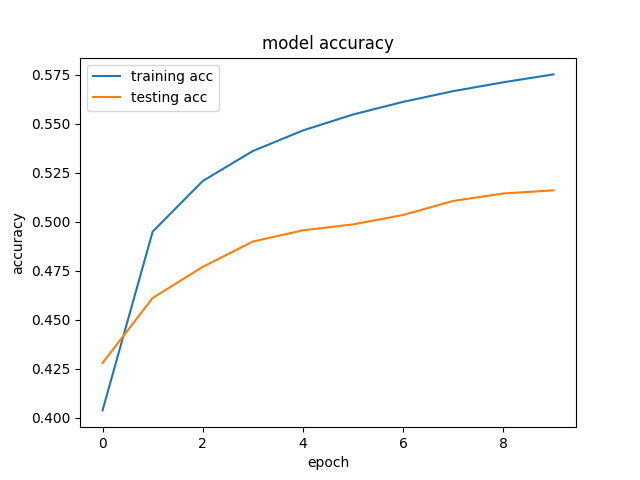

In [1]:
from IPython.display import Image, display
display(Image(filename='dbn-3x2048-sig-adagrad-noPT.png', embed=True))

Results for 3x2048 MLP with DBN-DNN pre-training and layer-wise pre-training
training acc: 58.54% testing acc: 52.12%

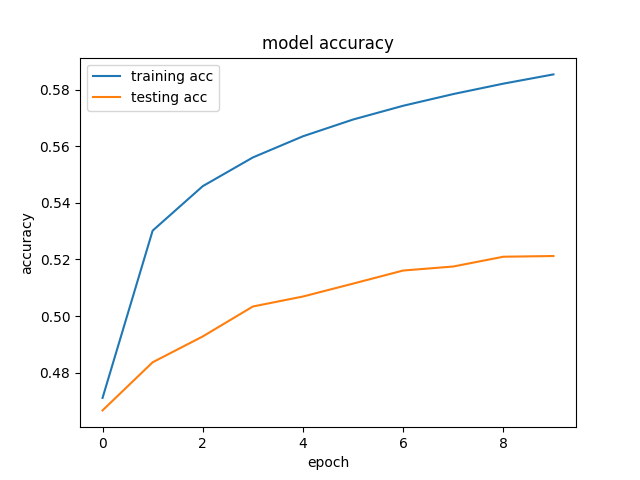

In [2]:
from IPython.display import Image, display
display(Image(filename='dbn-3x2048-sig-adagrad.png', embed=True))

Results for 3x2048 MLP with batch normalization only and 2048 batch size (instead of 20,000)
training acc: 65.41% testing acc: 58.50%

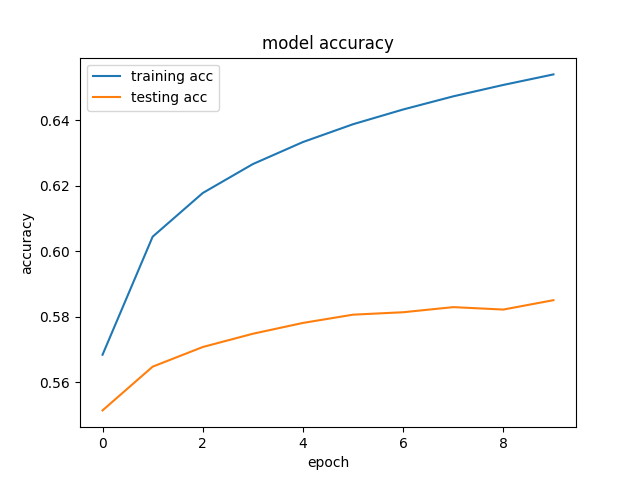

In [4]:
from IPython.display import Image, display
display(Image(filename='mlp1-3x2048-sig-adagrad-bn.png', embed=True))

# 27/6/17

In [ ]:
# generator for bracketing frames
# return a bracketed version of each utterance upon each call

def gen_bracketed_data(alldata,alllabels,nFrames,context_len):
	while 1:
		pos = 0
		nClasses = np.max(alllabels) + 1
		for i in xrange(len(nFrames)):
			data = alldata[pos:pos + nFrames[i]]
			labels = alllabels[pos:pos + nFrames[i]]

			labels = to_categorical(labels,num_classes=nClasses)
			pad_top = np.zeros((context_len,data.shape[1]))
			pad_bot = np.zeros((context_len,data.shape[1]))
			padded_data = np.concatenate((pad_top,data),axis=0)
			padded_data = np.concatenate((padded_data,pad_bot),axis=0)

			data = []
			for j in range(context_len,len(padded_data) - context_len):
				new_row = padded_data[j - context_len: j + context_len + 1]
				new_row = new_row.flatten()
				data.append(new_row)
			data = np.array(data)
			pos += nFrames[i]
			yield (data,labels)

Results for 3x2048 MLP with batch normalization using the generator
training acc: 67.6% testing acc: 44.09%

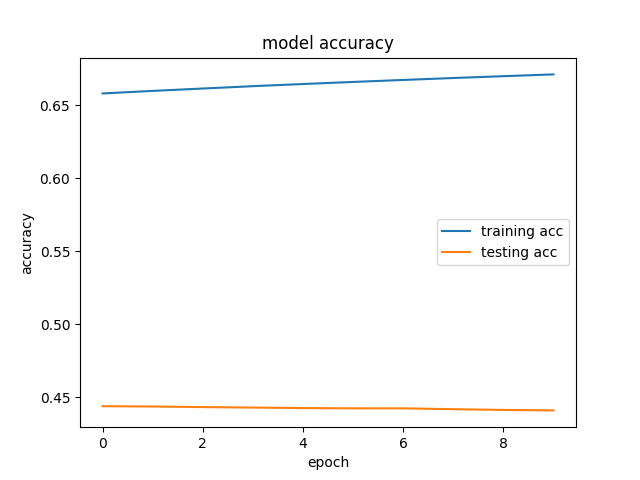

In [5]:
from IPython.display import Image, display
display(Image(filename='mlp1-3x2048-sig-adagrad-bn-perUTT.png', embed=True))

# 30/6/17

Obtained the official test file list from Nikolay and used it for testing

In [ ]:
# feature extraction for model en-us.cd_cont_4000
sphinx_fe -argfile ../../en_us.cd_cont_4000/feat.params -c etc/wsj0_et.fileids -di wav/ -do feat_et/ -mswav yes -eo mfc -ei wav 

In [ ]:
# decode for model en-us.cd_cont_4000
pocketsphinx_batch -hmm ../../en_us.cd_cont_4000 -lm ../../tcb20onp.Z.DMP -cepdir feat_et/ -cmn batch -hyp test2.hyp -ctl ../../GSOC/SI_ET_20.NDX -dict etc/cmudict.0.6d.wsj0 -lw 10 -beam 1e-80 -wbeam 1e-40 -bestpath no -fwdflat no

In [ ]:
# result
TOTAL Words: 5638 Correct: 4904 Errors: 843
TOTAL Percent correct = 86.98% Error = 14.95% Accuracy = 85.05%
TOTAL Insertions: 109 Deletions: 128 Substitutions: 606

# 2/7/16

- Obtained phoneme only model from Nikolay (en_us.ci_cont)
- feature extraction: sphinx_fe -argfile ../../en_us.ci_cont/feat.params -c etc/wsj0_train.fileids -di wav/ -do feat_ci_mls -mswav yes -eo mfc -ei wav -ofmt sphinx
- state segmentation: sphinx3_align -hmm ../../en_us.ci_cont/ -dict etc/cmudict.0.6d.wsj0 -ctl etc/wsj0_train.fileids -cepdir feat_ci_mls/ -cepext .mfc -insent etc/wsj0.transcription -outsent wsj0.out -stsegdir stateseg_ci_dir/ -cmn batch -lda ../../en_us.ci_cont/feature_transform
- decoding:  pocketsphinx_batch -hmm ../../en_us.ci_cont/ -lm ../../tcb20onp.Z.DMP -cepdir feat_ci_mls/ -argfile ../../en_us.ci_cont/feat.params  -cmn batch -hyp test_ci.hyp -ctl ../../GSOC/SI_ET_20.NDX -dict etc/cmudict.0.6d.wsj0 -lw 10 -beam 1e-80 -wbeam 1e-60

Res Net:
- 51 layers
- 25 2-layer residual blocks
- batch normalized
- relu activations

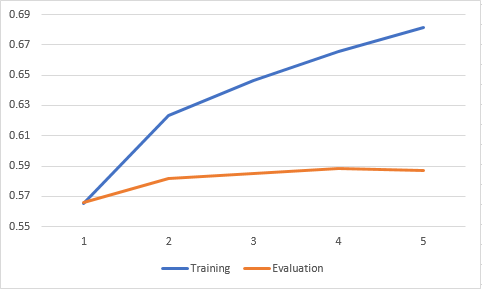

In [2]:
from IPython.display import Image, display
display(Image(filename='mlp4-25x2048-relu-adagrad.png', embed=True))

added convolution layer:
- 64 filters
- 4x4 kernel
- max-pooling

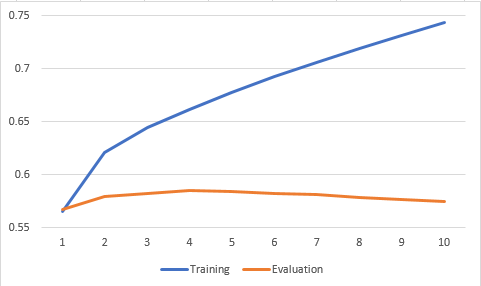

In [5]:
from IPython.display import Image, display
display(Image(filename='mlp4-25x2048-relu-adagrad-conv.png', embed=True))

In [ ]:
pocketsphinx_batch -hmm ../../en_us.ci_cont/ -lm ../../tcb20onp.Z.DMP -cepdir senscores/ -cepext .sen -hyp NN.hyp -ctl ../../GSOC/SI_ET_20.NDX -dict etc/cmudict.0.6d.wsj0 -senin yes -compallsen yes -bestpath no -fwdflat no -remove_noise no -remove_silence no -logbase 1.0001

# 3/7/17

Reorganized data set based on recommendations from Nikolay:
- using only .wv1 files
- using only si_dt_20 files for dev
- using only si_et_20 files for eval

# 4/7/17

3x2048 MLP with batch normalization and layerwise pretraining with reorganized dataset

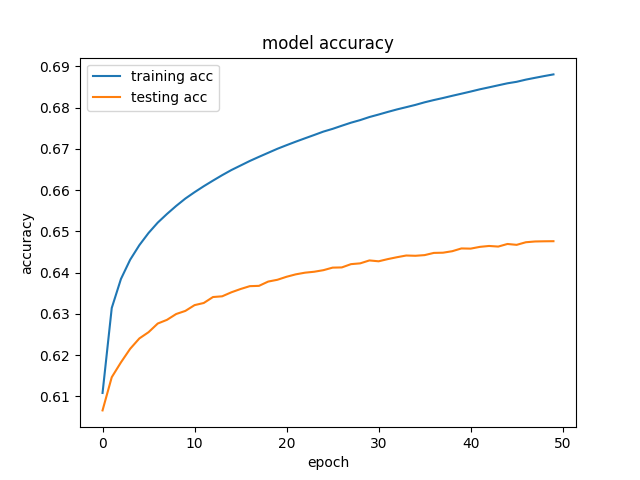

In [4]:
from IPython.display import Image, display
display(Image(filename='mlp1-3x2048-sig-adagrad-BN.png', embed=True))

# 4/7/17

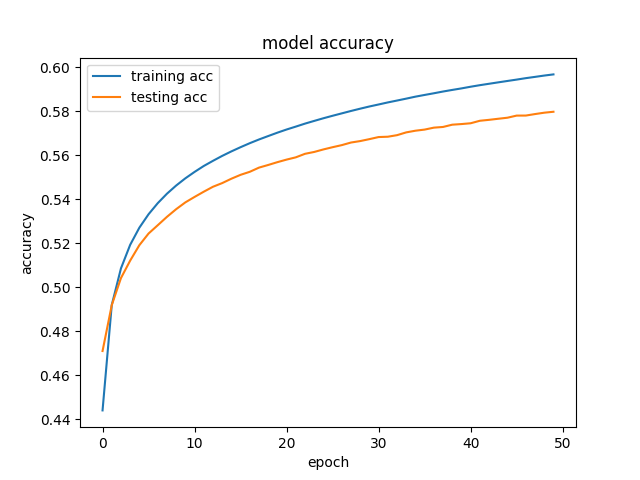

In [6]:
from IPython.display import Image, display
display(Image(filename='dbn-3x2048-sig-adagrad.png', embed=True))

# 6/7/17

In [ ]:
# added the -pl_window 0 flag to disable look-ahead search which dumps the senone scores for each frame multiple times
pocketsphinx_batch -hmm ../../en_us.ci_cont/ -lm ../../tcb20onp.Z.DMP -cepdir feat_ci_mfc/ -ctl ../../GSOC/SI_ET_20.NDX -dict etc/cmudict.0.6d.wsj0 -senlogdir sendump_ci/ -compallsen yes -bestpath no -fwdflat no -remove_noise no -remove_silence no -logbase 1.0001 -pl_window 0

Ran regression on Gaussian scores vs NN scores
- coefficient = -0.01787411
- intercept = 816.90396927

In [ ]:
TOTAL Percent correct = 9.91% Error = 92.28% Accuracy = 7.72%

# 7/7/17

Working with single utterance

Regression results: [coefficient, intercept] = [[ 0.15492159]] [ 461.37415579]]

Output from the gaussian:
THE FIRM SAID IT DOESN'T COMMENT ON THE STOCK RECOMMENDATIONS OR EARNINGS ESTIMATES (11_14_1/wsj0/si_et_20/445/445c0403.wv1.flac -13760)


Output from NN (scaled and translated using regression results):
OYSTER AUSIMONT CHOICE OYSTER ZHAO CHU JACQUES (11_14_1/wsj0/si_et_20/445/445c0403.wv1.flac -8190803)


# 8/7/17

Plotted the best senone for the gaussian and dnn

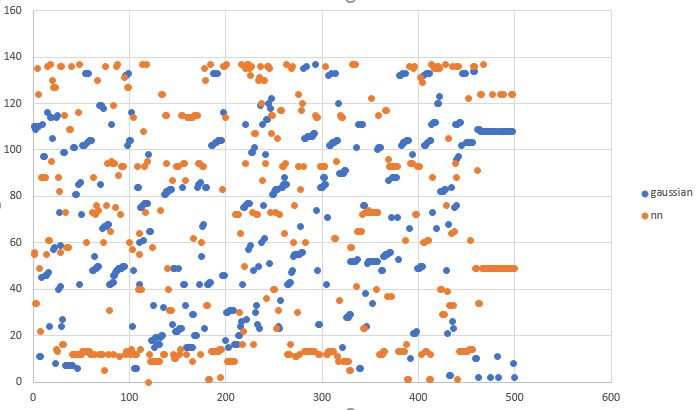

In [1]:
from IPython.display import Image, display
display(Image(filename='dnn-vs-gau.jpg', embed=True))

# 9/7/17

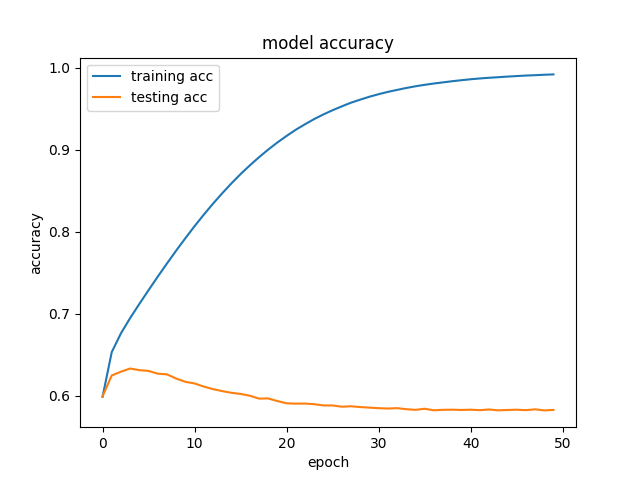

In [1]:
from IPython.display import Image, display
display(Image(filename='mlp4-0x2048-adagrad.png', embed=True))

read through the decoder code and found a normalization procedure


In [ ]:
best = (int32) 0x7fffffff;
	n = 0;
	for (i = 0; i < n_senone_active; i++) {
	    int32 s = senone_active[i] + n;
	    senscr[s] = senone_eval(sen, s, msg->dist[sen->mgau[s]], topn);
	    if (best > senscr[s]) {
		best = senscr[s];
	    }
	    n = s;
	}

	/* Normalize senone scores */
	n = 0;
	for (i = 0; i < n_senone_active; i++) {
	    int32 s = senone_active[i] + n;
	    int32 bs = senscr[s] - best;
	    if (bs > 32767)
		bs = 32767;
	    if (bs < -32768)
		bs = -32768;
	    senscr[s] = bs;
	    n = s;
	}

modified my code by:
- multiplying the log-likelihoods by -1 and subtracting the best score
- dividing score for each state by the frequency of that state in the training data

In [ ]:
scores /= freqs
scores = np.log(scores)/np.log(1.0001)
scores *= -1
scores -= np.min(scores,axis=1).reshape(-1,1)
scores *= 0.1 * 0.02744634

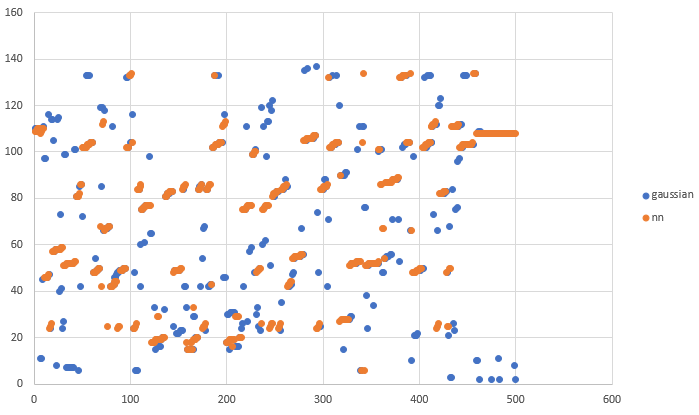

In [2]:
from IPython.display import Image, display
display(Image(filename='dnn-vs-gau-2.png', embed=True))

regression coefficient = 0.00296036

In [ ]:
TOTAL Words: 5638 Correct: 4346 Errors: 1540
TOTAL Percent correct = 77.08% Error = 27.31% Accuracy = 72.69%
TOTAL Insertions: 248 Deletions: 150 Substitutions: 1142

32% improvement on baseline with the context independent model

possibly overly optimistic since we regressed on the test data itself

Generated scores for the dev files

regression coefficient = 0.002744634

In [ ]:
pocketsphinx_batch -hmm ../../en_us.ci_cont/ -lm ../../tcb20onp.Z.DMP -cepdir senscores/ -cepext .sen -hyp NN2.hyp -ctl ../../GSOC/SI_ET_20.NDX -dict etc/cmudict.0.6d.wsj0 -compallsen yes -logbase 1.0001 -pl_window 0 -senin yes

In [ ]:
pocketsphinx_batch -hmm ../../en_us.ci_cont/ -lm ../../tcb20onp.Z.DMP -cepdir senscores/ -cepext .sen -hyp NN2.hyp -ctl ../../GSOC/SI_ET_20.NDX -dict etc/cmudict.0.6d.wsj0 -compallsen yes -logbase 1.0001 -pl_window 0 -senin yes

IMPORTANT: -pl_window 0 is required otherwise you'll get very high error rates

# 11/7/17

In [ ]:
 pocketsphinx_batch -hmm ../../en_us.cd_cont_4000/ -lm ../../tcb20onp.Z.DMP -cepdir feat_cd_mfc/ -ctl etc/wsj0_dev.fileids -dict etc/cmudict.0.6d.wsj0 -senlogdir sendump_cd/ -compallsen yes -logbase 1.0001 -pl_window 0 -beam 1e-80 -wbeam 1e-60 -lw 10.0

In [ ]:
 pocketsphinx_batch -hmm ../../en_us.cd_cont_4000/ -lm ../../tcb20onp.Z.DMP -cepdir senscores_cd/ -cepext .sen -hyp NN_et_cd.hyp -ctl ../../GSOC/SI_ET_20.NDX -dict etc/cmudict.0.6d.wsj0 -senin yes -compallsen yes -logbase 1.0001 -pl_window 0

In [ ]:
pocketsphinx_batch -hmm ../../en_us.cd_cont_4000/ -lm ../../tcb20onp.Z.DMP -cepdir senscores_dev_cd/ -cepext .sen -hyp NN_dev_cd.hyp -ctl etc/wsj0_dev.fileids -dict etc/cmudict.0.6d.wsj0 -senin yes -compallsen yes -logbase 1.0001 -pl_window 0

Testing on single utterance

regression coeff = 0.000282001 intercept = 271.10506735

# 13/7/17

error against language weight

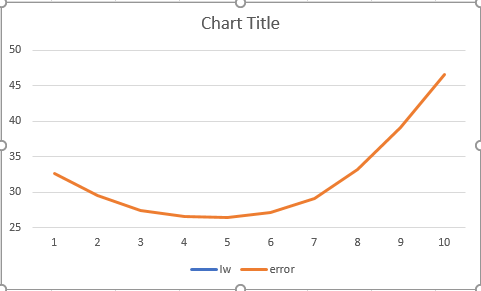

In [2]:
from IPython.display import Image, display
display(Image(filename='lw-vs-err.png', embed=True))

# 14/7/17

- modified data to contain values from 40 filterbanks
- increased the number of the context frames to 5
- tried out several NNs
- tried replacing the softmax with gradient booting techniques
- halved learning rate if val_loss didn't increase for 5 iterations

8x2048 mlp with batch normalization

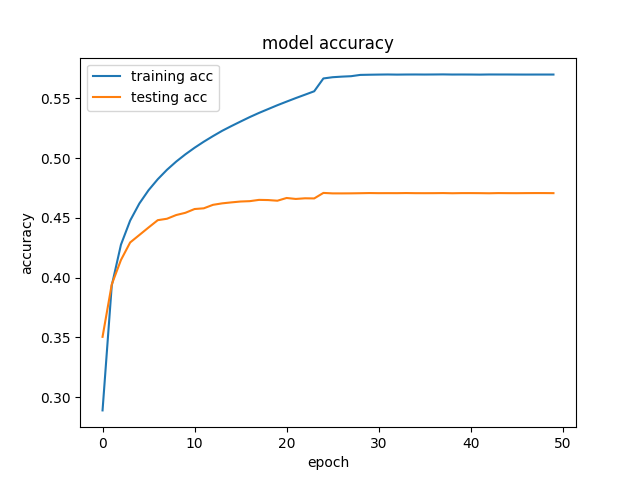

In [3]:
from IPython.display import Image, display
display(Image(filename='mlp1-8x2048-sig-adagrad-cd.png', embed=True))

single layer mlp with 5120 units and batch normalization with ADAM optimizer

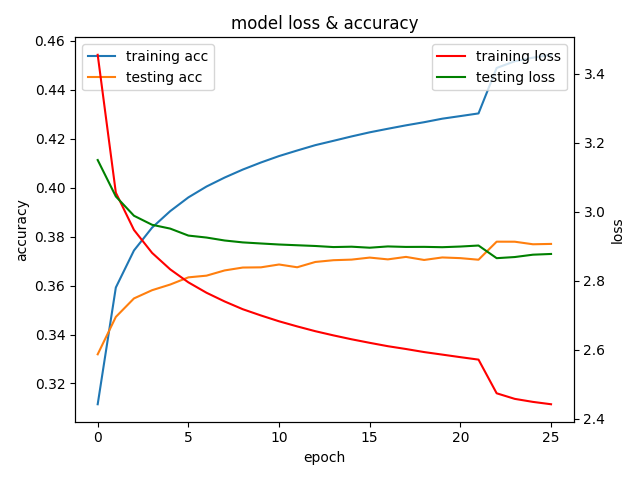

In [5]:
from IPython.display import Image, display
display(Image(filename='mlp1-1x5120-adagrad-cd.png', embed=True))

convolutional NN:
- 1 conv layer: 64 filters, 6x8 kernel, 2x2 max pooling
- 1 hidden layer 5120 units
- weights regularized with coefficient 0.01

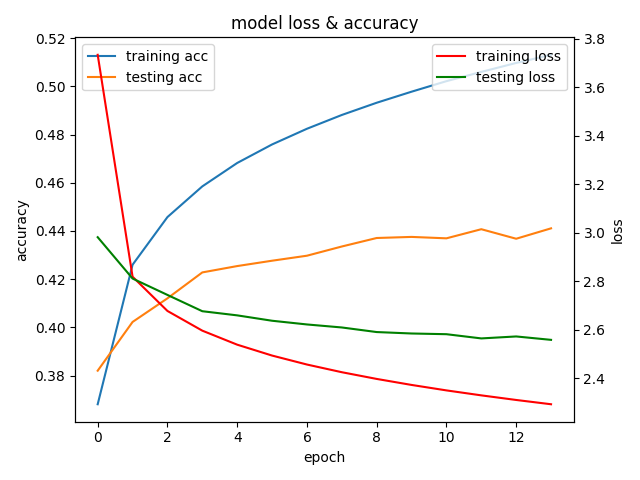

In [1]:
from IPython.display import Image, display
display(Image(filename='mlp4-0x5120-adagrad-cd-conv-reg.png', embed=True))

Same configuration but with exponential boosting instead of softmax

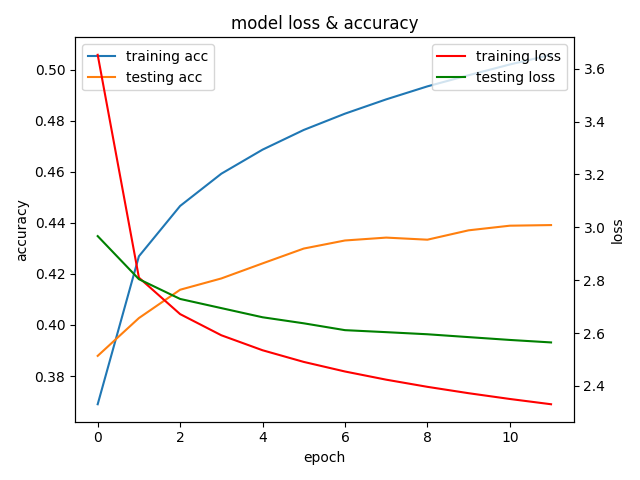

In [2]:
from IPython.display import Image, display
display(Image(filename='mlp4-0x5120-adagrad-cd-conv-reg-linBoost.png', embed=True))

# 15/7/17

# 17/7/17

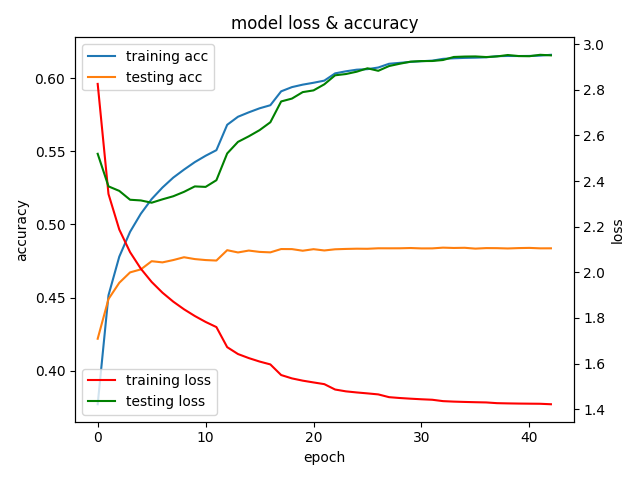

In [3]:
from IPython.display import Image, display
display(Image(filename='mlp4-2x2560-cd-adam-bn-drop-conv-noshort.png', embed=True))

The chopiness is due to deepnet0 killing the process and when I resumed it started from a higher loss

wrote code to interface the NN with C

In [ ]:
# Keras client
import os
CUDA_VISIBLE_DEVICES = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = CUDA_VISIBLE_DEVICES
from keras.models import load_model
import numpy as np
import socket
import struct
import time
def predictFrame(model_name,frame,weight=1,offset=0):
	model = load_model(model_name)
	scores = model.predict(frame)
	
	n_active = scores.shape[1]
	# print freqs
	# scores /= freqs + (1.0 / len(freqs))
	scores = np.log(scores)/np.log(1.0001)
	scores *= -1
	scores -= np.min(scores,axis=1).reshape(-1,1)
	# scores = scores.astype(int)
	scores *= 0.1 * weight
	scores += offset
	truncateToShort = lambda x: 32676 if x > 32767 else (-32768 if x < -32768 else x)
	vf = np.vectorize(truncateToShort)
	scores = vf(scores)
	print scores
	r_str = struct.pack('%sh' % len(scores[0]), *scores[0])

	# scores /= np.sum(scores,axis=0)
	return r_str

if __name__ == '__main__':
	HOST, PORT = '', 9000
	listen_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
	listen_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
	listen_socket.bind((HOST, PORT))
	listen_socket.listen(1)
	print 'Serving HTTP on port %s ...' % PORT
	while True:
	    client_connection, client_address = listen_socket.accept()
	    packet_len = struct.unpack('i',client_connection.recv(4))[0]
	    print packet_len
	    full_req = ""
	    while len(full_req) < packet_len:
	    	partial_req = client_connection.recv(1024)
	    	full_req += partial_req
	    print len(full_req)
	    [model_name,frame] = full_req.split('\r\n')
	    print model_name
	    frame = list(struct.unpack('%sd' % 440, frame))
	    frame = np.array([frame])
	    resp = str(predictFrame(model_name,frame))
	    print time.time()
	    client_connection.send(resp)
	    print time.time()

In [ ]:
# C-server
#include <stdio.h>
#include <string.h>
#include <sys/types.h>
#include <sys/socket.h>
#include <netinet/in.h>
#include <arpa/inet.h>
#include <netdb.h>
#include "stdarg.h"
#include "stdio.h"
#include <string.h>
#include <errno.h>
#include <time.h>

int Send(int fd, const void *buf, size_t len)
{
    int n;
    if ((n = send(fd, buf, len, 0)) < 0)
    {
        printf("send failed\n");
        return -1;
    }
    return n;
}

int Recv(int fd, void *buf, size_t len)
{
    int n;
    if ((n = recv(fd, buf, len, 0)) < 0)
    {
        printf("send failed\n");
        return -1;
    }
    return n;
}

int open_server_socket(char *my_ip, char *server_ip, int port)
{
    int server_sock;
    struct sockaddr_in my_addr;
    struct sockaddr_in serveraddr;

    if ((server_sock = socket(AF_INET, SOCK_STREAM, 0)) < 0)
    {
        return -1;
    }

    bzero((char *)&my_addr, sizeof(my_addr));
    my_addr.sin_family = AF_INET;
    inet_aton(my_ip, &(my_addr.sin_addr));
    my_addr.sin_port = 0;
    if (bind(server_sock, (struct sockaddr *)&my_addr, sizeof(my_addr)) < 0)
    {
        printf("open_server_socket: binding failiure: %s\n", strerror(errno));
        return -1;
    }

    bzero((char *) &serveraddr, sizeof(serveraddr));
    serveraddr.sin_family = AF_INET; 
    inet_pton(AF_INET, server_ip, &(serveraddr.sin_addr)); 
    serveraddr.sin_port = htons((unsigned short)port); 
    if (connect(server_sock, (struct sockaddr *)&serveraddr, sizeof(serveraddr)) < 0)
    {
        printf("open_server_socket: connect failed\n");
        return -1;
    }
    return server_sock;
}

int main(){
	int16_t score_buf[4138];
	
	char* model_name = "mlp4-2x2560-cd-adam-bn-drop-conv-noshort_CP.h5\r\n";
    int model_name_len = strlen(model_name);
    int packet_len = model_name_len+(440*8);
	int server_sock = open_server_socket("127.0.0.1","0.0.0.0",9000);
    printf("%d\n", model_name_len);
    Send(server_sock,&packet_len,4);
	Send(server_sock,model_name,strlen(model_name));
    time_t mytime;
	Send(server_sock,feat_buf_cd,440*8);
	Recv(server_sock,score_buf,4138*8);
    printf("%lu\n", (unsigned long)time(NULL)); 
	printf("%d\n", score_buf[4137]);
}

# 21/7/17

Updated graph above for 5-layered CNN

integrating NN decoder using TCP with Pocketsphinx

In [ ]:
# commandline for running with context_independent model train on 9x25D log spectra
../../sphinx/pocketsphinx/src/programs/pocketsphinx_batch -hmm ../../en_us.ci_cont_2/ -lm ../../tcb20onp.Z.DMP -cepdir feat_ci_dev_mls/  -cmn batch -hyp test_ci_2-2.hyp -ctl etc/wsj0_dev.fileids -dict etc/cmudict.0.6d.wsj0 -nnmgau ../../GSOC/bestModels/best_CI.h5 -pl_window 0 -ceplen 25 -ncep 25

# 22/7/17

#### finished integration with PS, code at https://github.com/shinigami1494/pocketsphinx

# 23/7/17

no updates for today

# 24/7/17

Read the CTC paper and tried to figure out the error in the equations

# 25/7/17

The CTC objective function and it derivative

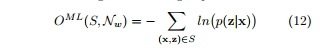

In [1]:
from IPython.display import Image, display
display(Image(filename='ctc_obj.png', embed=True))

Where: 
- z is the true labels
- x is the utterance
- N_w is the neural network

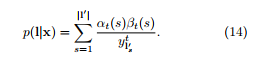

In [3]:
from IPython.display import Image, display
display(Image(filename='ctc_prob.PNG', embed=True))

where:
- p(l|x) is the probablity of the label sequence l given utterance x
- y_t is the output of the softmax for frame t
- l' is the sequence l with blanks and repeated labels removed

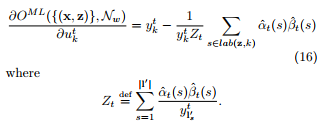

In [2]:
from IPython.display import Image, display
display(Image(filename='ctc_obj_der.png', embed=True))

Where:
- u_t is the exponentiated outputs of the NN for frame t(unormalized output of the softmax layer)
- lab(z,k) is the set of positions in the label sequence z where label k occurs

Trying to use the tensorflow CTC implementation with my current DNN models

# 26/7/17

In [ ]:
def mlp_wCTC(input_dim,output_dim,depth,width,BN=False):
	x = Input(name='x', shape=(1000,input_dim))
	h = x
	for i in range(depth-1):
		h = Dense(width,activation='sigmoid')(h)
		if BN:
			BatchNormalization()(h)
	out = Dense(output_dim+1,name='out')(h)
	# out = Activation('softmax', name='out')(h)
	# a = 1.0507 * 1.67326
	# b = -1
	# # out = Lambda(lambda x : a * K.pow(x,3) + b)(h)
	# out = Lambda(lambda x: a * K.exp(x) + b, name='out')(h)
	y = Input(name='y',shape=[1000],dtype='int32')
	x_len = Input(name='x_len', shape=[1],dtype='int32')
	y_len = Input(name='y_len', shape=[1],dtype='int32')

	dec = Lambda(decode, output_shape=decode_output_shape, name='decoder')([out,x_len])

	loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([out, y, x_len, y_len])
	model = Model(inputs=[x, y, x_len, y_len], outputs=[loss_out,dec])

	sgd = SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True, clipnorm=5)
	opt = Adam(lr=0.0001,clipnorm=5)
	model.compile(loss={'ctc': lambda y_true, y_pred: y_pred},
					optimizer=opt)
	return model

In [ ]:
# Dataset generator
def gen_data(alldata,alllabels,batch_size):
	while 1:
		for i in range(batch_size,alldata.shape[0]+1,batch_size):
			x = alldata[i-batch_size:i]
			y = alllabels[i-batch_size:i].reshape(batch_size,alllabels.shape[1])
			y_len = []
			for b in y:
				pad_len = 0
				while pad_len < len(b) and int(b[pad_len]) != 138:
					pad_len += 1
				y_len.append(pad_len)
			y_len = np.array(y_len)
			x_len = y_len
			inputs = {'x': x,
					'y': y,
					'x_len': x_len,
					'y_len': y_len}
			outputs = {'ctc': np.ones([batch_size]),
						'decoder': y}
			yield(inputs,outputs)

Getting "NO PATH FOUND ERROR" and infinity

# 27/7/17

Still Getting "NO PATH FOUND ERROR" and infinity

# 28/7/17

In [ ]:
# Using TF's loss code without the Keras wrapper
# setting preprocess_collapse_repeated=False gives reasonable loss
# ISSUE: does not produce repeated labels -> cannot be plugged into pocketsphinx as is
ef ctc_lambda_func(args):
	y_pred, labels, input_length, label_length = args
	label_length = math_ops.to_int32(array_ops.squeeze(label_length))
	input_length = math_ops.to_int32(array_ops.squeeze(input_length))
	labels = K.ctc_label_dense_to_sparse(labels,label_length)
	return tf.nn.ctc_loss(labels,y_pred,input_length,
    				preprocess_collapse_repeated=False,
    				ctc_merge_repeated=True,
    				time_major=False)

# 1/7/17

setting up pyfst on Ubuntu (Windows 10 sub-system)

wrote code for the forward pass (refer to fst.ipynb)

NOTE:
- Currently not accounting for blanks, need to fix that

OUTPUT OF FORWARD PASS ON "GOOD"

In [ ]:
# alpha[time_idx][symbol]
alpha = {0: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0014717934129675134,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 1: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 1.6364725817911244e-05,
  'G2': 1.6162776269624453e-05,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 2: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 6.811073603014045e-08,
  'G2': 3.4473579868376394e-08,
  'G3': 1.8681306232935016e-07,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 3: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 1.1123746036422873e-09,
  'G3': 1.4220370105751502e-09,
  'UH1': 2.1000080210032426e-09,
  'UH2': 0.0,
  'UH3': 0.0},
 4: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 3.294422563282797e-12,
  'UH1': 3.7434521615554155e-11,
  'UH2': 4.005348351057349e-12,
  'UH3': 0.0},
 5: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 1.9604090430399363e-13,
  'UH2': 3.691790607330902e-13,
  'UH3': 4.7801628351455386e-14},
 6: {'D1': 1.1957930530885402e-16,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 2.5056295697263896e-15,
  'UH3': 6.423001459499598e-16},
 7: {'D1': 4.087350111528377e-19,
  'D2': 1.684505962315879e-19,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 3.539097960922723e-17},
 8: {'D1': 4.402725981326733e-19,
  'D2': 4.892585660708592e-21,
  'D3': 2.1956064549383326e-21,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 9: {'D1': 0.0,
  'D2': 1.8748051807806946e-21,
  'D3': 6.179627726341555e-23,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 10: {'D1': 0.0,
  'D2': 0.0,
  'D3': 1.3247842580310856e-23,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0}}

# 2/7/17

wrote the back pass code (code in fst.ipynb)

OUTPUT OF BACKWARD PASS ON "GOOD"

In [ ]:
{1: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 3.234937671111563e-22,
  'G2': 8.677662552511044e-21,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 2: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 4.9862209152181135e-21,
  'G2': 2.4107819575771124e-20,
  'G3': 7.660860414098061e-19,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 3: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 1.1980216761858216e-18,
  'G3': 2.154888057681078e-17,
  'UH1': 4.473169496859423e-17,
  'UH2': 0.0,
  'UH3': 0.0},
 4: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 1.1048277592881657e-16,
  'UH1': 3.2427910070324514e-15,
  'UH2': 7.364628037569548e-16,
  'UH3': 0.0},
 5: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 8.499481323548086e-14,
  'UH2': 2.2010474358696217e-13,
  'UH3': 1.6602341793783255e-13},
 6: {'D1': 6.863103517546181e-12,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 1.7658299506671125e-11,
  'UH3': 7.04817202279755e-12},
 7: {'D1': 5.923075381399958e-10,
  'D2': 2.151206674757991e-09,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 3.983359531818144e-09},
 8: {'D1': 3.543088091058004e-07,
  'D2': 7.49748660455615e-07,
  'D3': 7.773447752344201e-07,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 9: {'D1': 0.0,
  'D2': 2.8809774460803683e-05,
  'D3': 5.96391901523288e-05,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 10: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.006840768669920679,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0}}

# 3/7/17

no updates for today

# 4/7/17

started implementing forward backward in tensor flow

modified the dataset to include utterance graphs

# 5/7/17

picking up TF basics

# 6/7/17

ran in to issues with indexing the mem-table for alpha and beta

# 7/7/17

Issues persist

will work with TF's for now